In [ ]:
'''Zwischenanalyse (nach Schritt 3)
Untersuchung Parken und rechte Abstände
- Wieviele Rechte Messwerte sind an Parkständen?
- 
'''

In [2]:
import json 
import pandas as pd
import geopandas as gpd
import os

import glob                             #verwendung von 'wildacards' in Dateinamen
from tqdm import tqdm                   #fuer Darstellen eines Fortschrittsbalkens
import matplotlib.pyplot as plt

import pylab
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import anderson
from scipy.stats import jarque_bera
from datetime import date
from shapely import wkt

In [3]:
path_OBS_OSM = '../OSM-OBS_merged'
path_OBS_OSM = path_OBS_OSM + '/*.gpkg'

#liest alle obs-Dateien ein und packt sie in eine liste. 
files_OBS_OSM = glob.glob(path_OBS_OSM)

max(files_OBS_OSM, key=os.path.getctime)

'../OSM-OBS_merged/OSM-OBS_230623.gpkg'

In [6]:
gdf_klass=gpd.read_file(max(files_OBS_OSM, key=os.path.getctime)) #klassifizierte und mit OSM gemergte OBS-Messwerte
gdf_klass['Radinfra'] = gdf_klass['Radinfra'].astype('string') #Datentyp String für Radinfra Spalte. Vorbereitung für das Auslesen.
gdf_klass.head()

,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,lanes,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,cycleway_right_bicycle,cycleway_left_bicycle,...,parking_left,parking_right,cycleway_right_separation_right,cycleway_left_separation_right,cycleway_both_separation_right,parking_both_orientation,parking_left_orientation,parking_right_orientation,cycleway_right_separation_left,cycleway_left_separation_left,cycleway_both_separation_left,cycleway_right_separation_both,cycleway_left_separation_both,cycleway_both_separation_both,cycleway_right_marking_both,cycleway_left_marking_both,cycleway_both_marking_left,cycleway_both_marking_right,cycleway_both_traffic_sign,cycleway_both_marking_both,cycleway_right_buffer_right,cycleway_left_buffer_right,cycleway_both_buffer_right,cycleway_right_buffer_left,cycleway_left_buffer_left,cycleway_both_buffer_left,cycleway_right_buffer_both,cycleway_left_buffer_both,cycleway_both_buffer_both,cycleway_marking_both,cycleway_marking_left,cycleway_marking,cycleway_right_marking,cycleway_left_marking,cycleway_traffic_sign,parking_orientation,other_tags,geometry_y,Radinfra,geometry
0,1.82,NaN,-1,28496022,1.913791,4.611111,2022-05-09 15:22:33+00:00,adfc-brandenburg,28496022.0,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,parallel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","-1,PStreifen, laengsparken,Gesamtbreite:15,",POINT (13.42786 52.47392)
1,0.71,NaN,-1,28496022,1.927347,1.666667,2022-05-09 15:22:48+00:00,adfc-brandenburg,28496022.0,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,parallel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4276113 52.4743919, 13.4276523 ...","-1,PStreifen, laengsparken,Gesamtbreite:15,",POINT (13.42766 52.47430)
2,1.57,0.50,-1,849599088,1.934648,4.500000,2022-05-09 15:23:26+00:00,adfc-brandenburg,849599088.0,Hermannstraße,secondary,NaN,30,2,yes,asphalt,NaN,NaN,no,NaN,NaN,15,NaN,good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""foot""=>""use_sidepath"",""lane_markings""=>""yes"",...","LINESTRING (13.4273296 52.4749344, 13.4273762 ...","-1,Gesamtbreite:15,",POINT (13.42738 52.47485)
3,1.26,0.74,-1,568336446,1.878984,4.138889,2022-05-09 15:23:33+00:00,adfc-brandenburg,568336446.0,NaN,service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""access""=>""customers"",""hgv""=>""no"",""maxheight""=...","LINESTRING (13.4274642 52.4752813, 13.4277362 ...","-1,Misch",POINT (13.42746 52.47528)
4,2.05,NaN,-1,816236476,2.021442,4.083333,2022-05-09 15:23:44+00:00,adfc-brandenburg,816236476.0,NaN,service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Text(0.5, 1.0, 'Anzahl von Messwerten nach\nInfrastrukturtyp und Überholabstand')

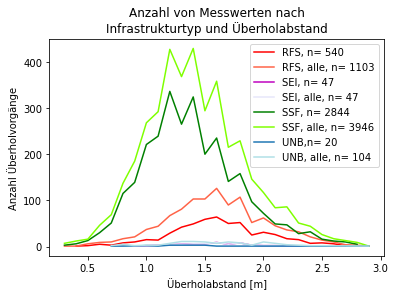

In [29]:
#Plotten der unterschiedlichen Infrastrukturtypen
gdf_klass['Radinfra'] = gdf_klass['Radinfra'].astype('string')
gdf_RFS = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_SEI = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Seitenstreifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_SSF = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*Schutzstreifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_UNB = gdf_klass[(gdf_klass['Radinfra'].str.contains(r'^(?=.*,...streifen)(?=.*Radbrei)', regex=True) == True)].copy()
gdf_RFS_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Radfahrstreifen', regex=True) == True)].copy()
gdf_SEI_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Seitenstreifen', regex=True) == True)].copy()
gdf_SSF_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('Schutzstreifen', regex=True) == True)].copy()
gdf_UNB_all = gdf_klass[(gdf_klass['Radinfra'].str.contains('...streifen', regex=False) == True)].copy()

#Datensätze ohne gemessenen Ü*berholabstand (links) löschen
gdf_RFS = gdf_RFS.dropna(subset=['distance_overtaker'])
gdf_SEI = gdf_SEI.dropna(subset=['distance_overtaker'])
gdf_SSF = gdf_SSF.dropna(subset=['distance_overtaker'])
gdf_UNB = gdf_UNB.dropna(subset=['distance_overtaker'])
gdf_RFS_all = gdf_RFS_all.dropna(subset=['distance_overtaker'])
gdf_SEI_all = gdf_SEI_all.dropna(subset=['distance_overtaker'])
gdf_SSF_all = gdf_SSF_all.dropna(subset=['distance_overtaker'])
gdf_UNB_all = gdf_UNB_all.dropna(subset=['distance_overtaker'])

#Datens#tze zum Plot hinzufügen
plt.plot(gdf_RFS.groupby(gdf_RFS['distance_overtaker'].round(1))['distance_overtaker'].count(), "-r", 
         label = 'RFS, n= '+gdf_RFS['distance_overtaker'].count().astype('str'))       #Radfahrstreifen (rot)
plt.plot(gdf_RFS_all.groupby(gdf_RFS_all['distance_overtaker'].round(1))['distance_overtaker'].count(), 'tomato',
         label = 'RFS, alle, n= '+gdf_RFS_all['distance_overtaker'].count().astype('str'))#Radfahrstreifen (rot)
plt.plot(gdf_SEI.groupby(gdf_SEI['distance_overtaker'].round(1))['distance_overtaker'].count(), "-m",
         label = 'SEI, n= '+gdf_SEI['distance_overtaker'].count().astype('str'))     #SSeitentreifen (grün)
plt.plot(gdf_SEI_all.groupby(gdf_SEI_all['distance_overtaker'].round(1))['distance_overtaker'].count(), 'lavender',
         label = 'SEI, alle, n= '+gdf_SEI_all['distance_overtaker'].count().astype('str'))#Radfahrstreifen (rot)
plt.plot(gdf_SSF.groupby(gdf_SSF['distance_overtaker'].round(1))['distance_overtaker'].count(), "-g",     
         label = 'SSF, n= '+gdf_SSF['distance_overtaker'].count().astype('str')) #Schutzstreifen (grün)
plt.plot(gdf_SSF_all.groupby(gdf_SSF_all['distance_overtaker'].round(1))['distance_overtaker'].count(), "chartreuse",
         label = 'SSF, alle, n= '+gdf_SSF_all['distance_overtaker'].count().astype('str'))#Schutzstreifen (grün)
plt.plot(gdf_UNB.groupby(gdf_UNB['distance_overtaker'].round(1))['distance_overtaker'].count(), "-",
         label = 'UNB,n= '+gdf_UNB['distance_overtaker'].count().astype('str'))
plt.plot(gdf_UNB_all.groupby(gdf_UNB_all['distance_overtaker'].round(1))['distance_overtaker'].count(), "powderblue",
         label = 'UNB, alle, n= '+gdf_UNB_all['distance_overtaker'].count().astype('str'))       #Streifentyp unbekannt (blau)

plt.xlabel('Überholabstand [m]')
plt.ylabel('Anzahl Überholvorgänge')

#Erzeugen der Legende und Hinzufügen Titel
plt.legend()

label_head = 'Anzahl von Messwerten nach\nInfrastrukturtyp und Überholabstand'
plt.title(label_head)



In [ ]:
#Plotten der unterschiedlichen Infrastrukturtypen
gdf_klass['Radinfra'] = gdf_klass['Radinfra'].astype('string')
gdf_RFS = gdf_klass[(gdf_klass['Radinfra'].str.contains('Radfahrstreifen', regex=False) == True)].copy()
gdf_SSF = gdf_klass[(gdf_klass['Radinfra'].str.contains('Schutzstreifen', regex=False) == True)].copy()
gdf_UNB = gdf_klass[(gdf_klass['Radinfra'].str.contains('...streifen', regex=False) == True)].copy()

#Datensätze ohne gemessenen Ü*berholabstand (links) löschen
gdf_RFS = gdf_RFS.dropna(subset=['distance_overtaker'])
gdf_SSF = gdf_SSF.dropna(subset=['distance_overtaker'])
gdf_UNB = gdf_UNB.dropna(subset=['distance_overtaker'])

plt.plot(gdf_RFS.groupby(gdf_RFS['distance_overtaker'].round(1))['distance_overtaker'].count(), "-r",       #Radfahrstreifen (rot)
         gdf_SSF.groupby(gdf_SSF['distance_overtaker'].round(1))['distance_overtaker'].count(), "-g",     #Schutzstreifen (grün)
         gdf_UNB.groupby(gdf_UNB['distance_overtaker'].round(1))['distance_overtaker'].count(), "-")       #Streifentyp unbekannt (blau)
plt.xlabel('Überholabstand [m]')
plt.ylabel('Anzahl Überholvorgänge')
#Erzeugen der Legende
label_RFS = 'RFS, n= '+gdf_RFS['distance_overtaker'].count().astype('str')
label_SSF = 'SSF, n= '+gdf_SSF['distance_overtaker'].count().astype('str')
label_UNB = 'UNB, n= '+gdf_UNB['distance_overtaker'].count().astype('str')
plt.legend([label_RFS, label_SSF, label_UNB])
#erstellen von gdf für Radfahrstreifen (RFS) Schutzstreifen (SSF) und unbekannten Streifentyp (UNB)
